# Mercari Price Prediction

## Exploration

In this section we are going to check each feature, their correlation, and distribution. It is a descriptive analysis of the entire data. Graphically explain how the dataset is composed.

Load the data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.externals.joblib.parallel import cpu_count, Parallel, delayed
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import gc
import tempfile
import os
from joblib import load, dump

# Pretty display for notebooks
%matplotlib inline

In [12]:
train = pd.read_table('Dataset/train.tsv')
test = pd.read_table('Dataset/test.tsv')
prices = train["price"]
features = train.drop("price", axis = 1)

In [3]:
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
# Check for Nulls
print(train.isnull().any())

# types
train.dtypes

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool


train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [5]:
# Display a description of the dataset
display(train.describe())

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Feature analysis

#### 1) Price - Target value

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
85%      4.000000e+01
95%      7.500000e+01
98%      1.220000e+02
max      2.009000e+03
Name: price, dtype: float64


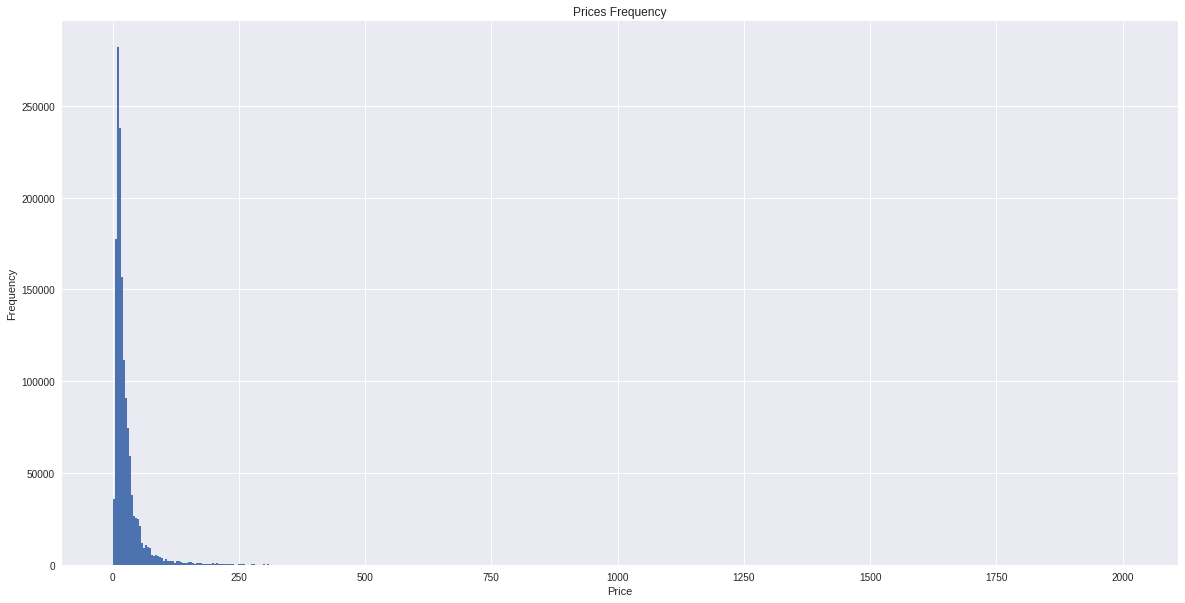

As we can see most of the information is within the range from $0 to $200.
We update the histogram to understand more the distribution of the data.
As mentioned above, 75% of the prices are between $0 and $29


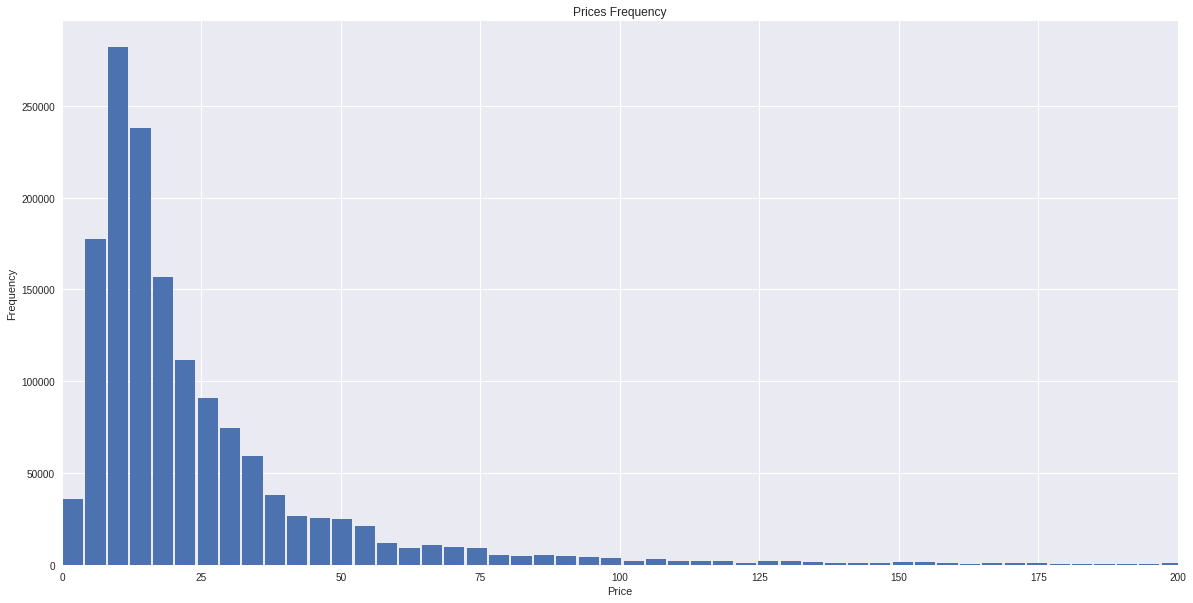

Products with price equal 0 = 874


In [7]:
print train.price.describe(percentiles=[.25, .50, .75, .85, .95, .98])

plt.figure(figsize=(20,10))
plt.hist(prices, bins = 500)
plt.title("Prices Frequency")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.savefig('priceFrequency1.png')
plt.show()


print("As we can see most of the information is within the range from $0 to $200.")
print("We update the histogram to understand more the distribution of the data.")
print("As mentioned above, 75% of the prices are between $0 and $29")
# the histogram of the data
plt.figure(figsize=(20,10))
plt.hist(prices, bins = 500, rwidth=0.9)
plt.title("Prices Frequency")
plt.xlabel("Price")
plt.xlim(0, 200)
plt.ylabel("Frequency")
plt.savefig('priceFrequency2.png')
plt.show()


print("Products with price equal 0 = " + str(prices.size - np.count_nonzero(prices)))



At first glance, we can observe from the histogram above that the distribution of the prices is not normal. Instead, it is more a positively skewed shape. Also, the prices' range is too wide, from $0.00 to $2009.00. Hence, in order to reduce the range, and have a close normal distribution, we will use the log function in the price.

But First, we need to remove the prices equal to 0 due to the fact that they do not apport nothing to our model, and could be considered just noise. For instance, in the subset that contains the items with prices equal to zero, we can find jeans levis, old navy shirts, Nike shoes, to name few. Clearly, none of these items could cost something close to zero.

In [8]:
sampleZero = np.where(train['price'] <= 0.0)

In [9]:
samples = pd.DataFrame(train.loc[sampleZero], columns = train.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
1,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
4,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
5,5237,Nursing Bra,3,Women/Underwear/Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
6,6175,"Multi Listing Bundled Package, Thanks",2,Electronics/Media/DVD,NaN,0.0,1,1)Large Collection of Full Length Strawberry S...
7,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
8,7622,Hands free earpiece,1,Electronics/Cell Phones & Accessories/Headsets,NaN,0.0,0,Wireless Bluetooth hands free used with Samsun...
9,10812,Vampire candy bowl,1,Home/Seasonal Décor/Halloween,NaN,0.0,0,New good condition for halloween


In [13]:
train = train.drop(train[train.price <= 0.0].index)
prices = train["price"]
features = train.drop("price", axis = 1)

In [14]:
train["logprice"] = np.log(train["price"]+1)
LogPrices = np.log(prices+1)

In [12]:
display(LogPrices.describe())

count    1.481661e+06
mean     2.980816e+00
std      7.459274e-01
min      1.386294e+00
25%      2.397895e+00
50%      2.890372e+00
75%      3.401197e+00
max      7.605890e+00
Name: price, dtype: float64

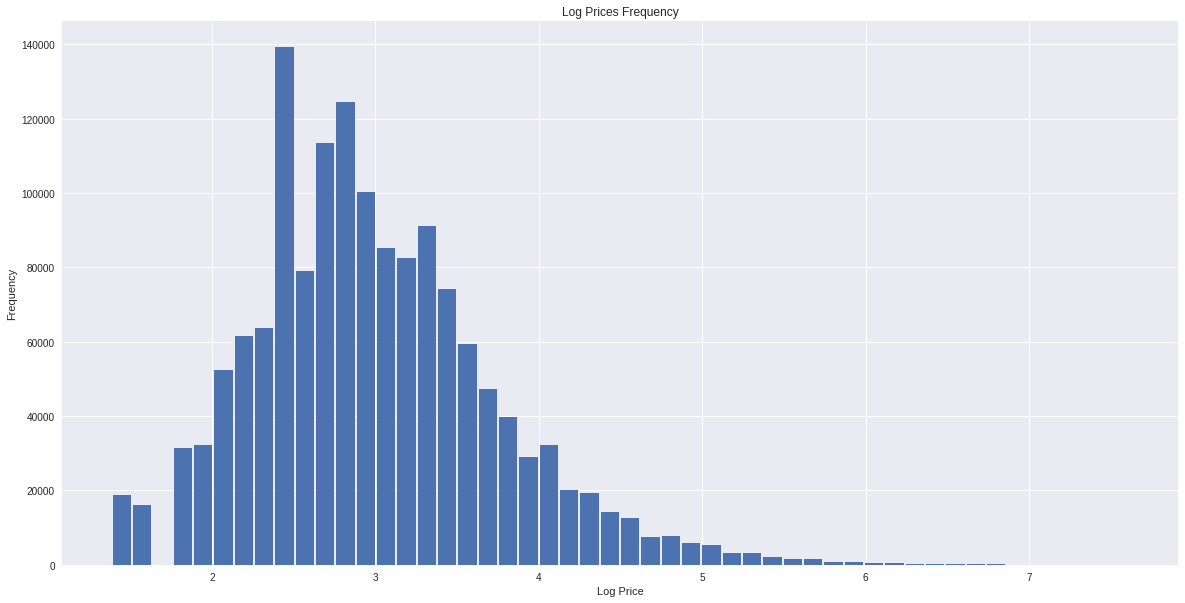

In [13]:
plt.figure(figsize=(20,10))
plt.hist(LogPrices, bins = 50, rwidth=0.9)
plt.title("Log Prices Frequency")
plt.xlabel("Log Price")
plt.ylabel("Frequency")
plt.show()

The histogram above shows the prices using the log functions. As we can see, the distribution is more normal, and the range is less dispersed.

#### 2) item_condition

Item condition is a categorical feature. It is a score from 1 to 5 that describes how the item's condition is. The range goes from "new" to "poor". The complete explanation can be found here: https://www.mercari.com/help_center/article/316/. We are going to verify the products´ condition based on this feature.

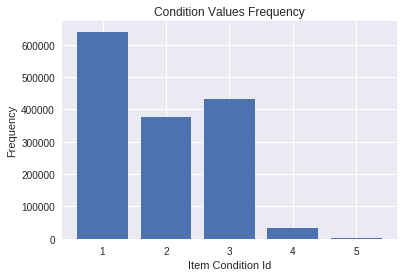

condition 1: 640246
condition 2: 375196
condition 3: 431892
condition 4: 31945
condition 5: 2382


In [14]:
n_groups = 5
sub1 = len(train.loc[(train['item_condition_id']==1)])
sub2 = len(train.loc[(train['item_condition_id']==2)])
sub3 = len(train.loc[(train['item_condition_id']==3)])
sub4 = len(train.loc[(train['item_condition_id']==4)])
sub5 = len(train.loc[(train['item_condition_id']==5)])

objects = ('1', '2','3','4','5')

y_pos = np.arange(len(objects))
performance = [sub1, sub2, sub3, sub4, sub5]
 
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.xlabel('Item Condition Id')
plt.title('Condition Values Frequency')
 
plt.show()

print('condition 1: ' + str(sub1))
print('condition 2: ' + str(sub2))
print('condition 3: ' + str(sub3))
print('condition 4: ' + str(sub4))
print('condition 5: ' + str(sub5))

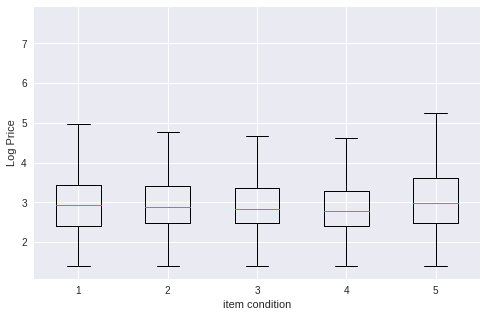

In [15]:
sub1 = train.loc[(train['item_condition_id']==1)]
sub2 = train.loc[(train['item_condition_id']==2)]
sub3 = train.loc[(train['item_condition_id']==3)]
sub4 = train.loc[(train['item_condition_id']==4)]
sub5 = train.loc[(train['item_condition_id']==5)]
data = [sub1.logprice,sub2.logprice,sub3.logprice,sub4.logprice,sub5.logprice]
# multiple box plots on one figure
plt.figure(figsize=(8,5))
plt.xlabel("item condition")
plt.ylabel("Log Price")
plt.boxplot(data)
plt.show()

From the box plot above, it can be seen that the mean log price for the five conditions is similar, around 3. Also, the interquartile range(IQR) from the first four conditions are between 2.5 and 3.2. In contrast, the third quartile from the condition with value 5 is higher, above 3.5 approximately, which could mean that products with a condition equal to 5 are more expensive. Moreover, it is clear from the chart that the maximum price declines from the condition 1 to 4 constantly and climb around 0.5 in the log price with condition 5.  

#### 3) Shipping

Products with shipping included: 662785
Products without the shipping included: 818876


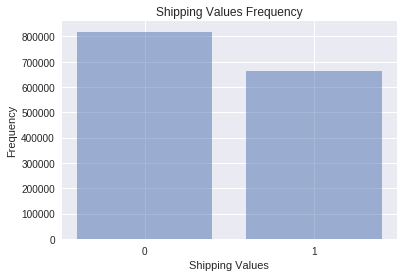

In [16]:

n_groups = 2
shipping = np.count_nonzero(train.shipping)
noShipping = train.shipping.size - shipping
frequency = (noShipping, shipping)

print ("Products with shipping included: "+str(shipping))
print ("Products without the shipping included: "+str(noShipping))

objects = ('0', '1')
y_pos = np.arange(len(objects))
performance = [noShipping,shipping]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.xlabel('Shipping Values')
plt.title('Shipping Values Frequency')
 
plt.show()

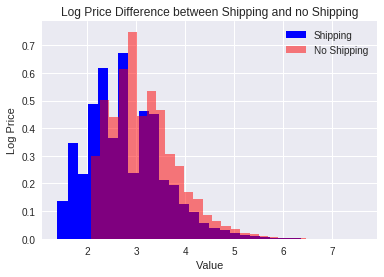

In [17]:
logPricesShipping =  train.loc[(train['shipping']==1)]
logPricesNoShipping = train.loc[(train['shipping']==0)]

plt.hist(logPricesShipping.logprice, bins=30, histtype='stepfilled', normed=True, color='b', label='Shipping')
plt.hist(logPricesNoShipping.logprice, bins=30, histtype='stepfilled', normed=True, color='r', alpha=0.5, label='No Shipping')
plt.title("Log Price Difference between Shipping and no Shipping")
plt.xlabel("Value")
plt.ylabel("Log Price")
plt.legend()
plt.show()

The shipping feature provides interesting information. At first glance, we observe that most of the products do not provide free shipping, the difference is 156091 items. But more interesting, contrary to what we could think that free shipping products are more expensive, the histogram above proves the opposite. The products with free shipping are cheaper than those where the client has to pay.  

After this feature, we conclude the analysis of continues values. Now we are going to analyse categorical variables.

#### 4) Category Name

First we can get the total number of categories. 

In [18]:
val = len(pd.value_counts(train['category_name']))
itemswithoutcategory = train['category_name'].isnull().sum()
print "The total number of unique categories is: " + str(val) + ", items without category: " + str(itemswithoutcategory)

The total number of unique categories is: 1287, items without category: 6314


In [19]:
categories = train['category_name'].value_counts()
categories.head(30)

Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T-Shirts                                  46349
Beauty/Makeup/Face                                             34320
Beauty/Makeup/Lips                                             29901
Electronics/Video Games & Consoles/Games                       26547
Beauty/Makeup/Eyes                                             25200
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24668
Women/Underwear/Bras                                           21254
Women/Tops & Blouses/Tank, Cami                                20270
Women/Tops & Blouses/Blouse                                    20269
Women/Dresses/Above Knee, Mini                                 20068
Women/Jewelry/Necklaces                                        19750
Women/Athletic Apparel/Shorts                                  19518
Beauty/Makeup/Makeup Palettes                                  19091
Women/Shoes/Boots                 

The presented table shows the top categories in the dataset. From the 1287 categories, we observe that from the top 10, 8 categories sell products for women. Only two categories are not women related, "Electronics/Video Games & Consoles/Games", and "Electronics/Cell Phones & Accessories/Cases, Covers & Skins".Moreover, from the entire 30 first categories, just 6 categories are not intended to sell products to women.This could tell us that Mercari is focused on selling products to women, or it could help them to develop marketing campaigns for them.

The given chart below presents the top 30 categories with the highest median price. Comparing the two list we can observe that the categories with high prices are not related to woman items. The highest price is located in the "Vintage & Collectibles/Antique/Furniture" category, however, it is just one item.

In general, the 30 categories with high prices only represent the 1.45%. There are 6 with 1 item, 5 categories with less than 5 items. There are only 6 categories with more than 1000 and less than 9000 items. Looking into details, these 6 categories can be divided in two: Electronics and Handbags.

This overview provides useful information to understand the distribution of the prices, with this information we can take further action in the pre-processing step. For example, we can train a model with and without the outliers and compare the results. It might be possible that the categories with few items only produce noise to our model or not.


In [20]:
#categoryPrice = train.groupby(["category_name"]).size().reset_index(name="count")
categoryPrice = train.groupby(["category_name"]).agg({'category_name':'size', 'price':'median'}).rename(columns={'category_name':'count','price':'median_price'})

Total items with the highest price by category: 21497
This 30 categories represent just the 1.45% from the total training set


,median_price,count
category_name,,
Vintage & Collectibles/Antique/Furniture,195.0,1
Kids/Strollers/Standard,145.0,15
Home/Home Appliances/Air Conditioners,131.0,42
Kids/Strollers/Lightweight,105.0,18
Sports & Outdoors/Golf/Women's Golf Clubs,100.0,4


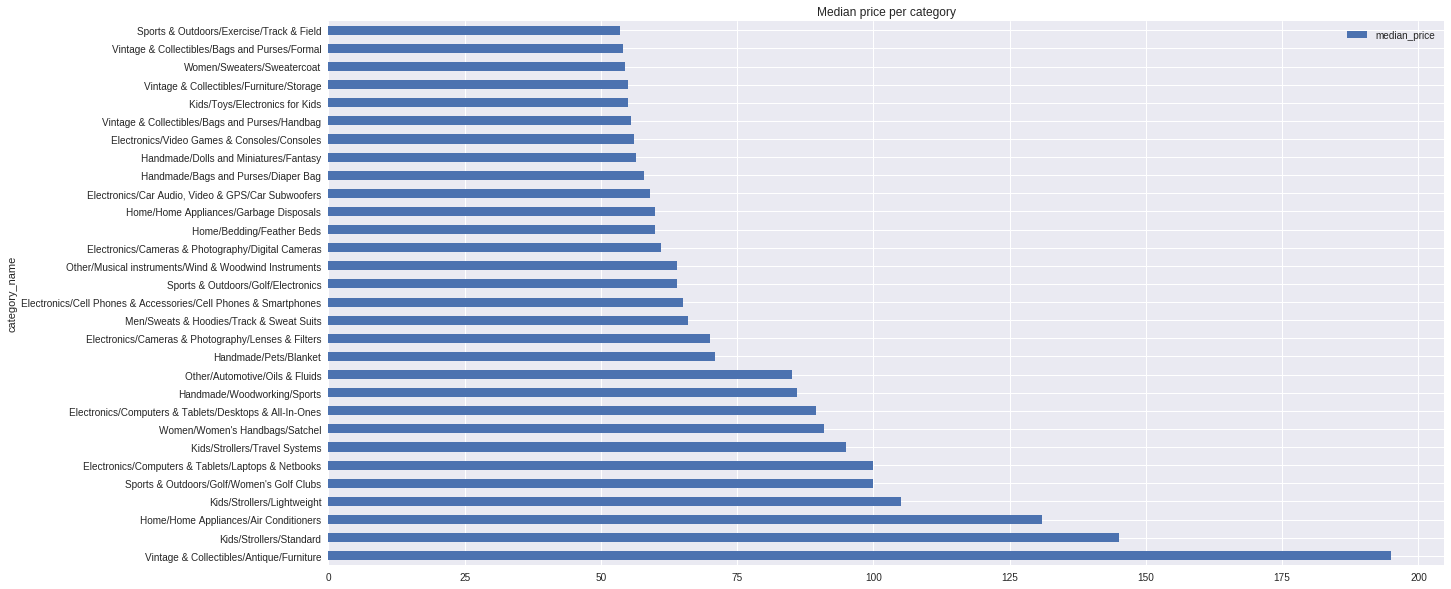

In [21]:
top30 = categoryPrice.sort_values("median_price", ascending=False).head(30)
top30.plot(y="median_price", kind="barh", figsize=(20,10), title="Median price per category")
itemsin30categories = top30["count"].sum()
print "Total items with the highest price by category: " + str(itemsin30categories)
percentageFromTotalSet = (float(itemsin30categories) * 100.0) / float(len(train.index))
print('This 30 categories represent just the %.2f' % percentageFromTotalSet + '% from the total training set')
top30.head()

We are going to split the feature category_name into 3 features, each containing one of the 3 levels that can be found on the original feature.

In [22]:
train[['category1', 'category2', 'category3']] = train.category_name.str.split('/', expand = True, n=2)
#train = train.drop(["category1","category2","category3","Category1","Category2","Category3"], axis=1)

In [23]:
totalCategories1Level = len(pd.value_counts(train['category1']))
totalCategories2Level = len(pd.value_counts(train['category2']))
totalCategories3Level = len(pd.value_counts(train['category3']))
print 'The total categories in the first level are ' +str(totalCategories1Level) + ' the second level has ' + str(totalCategories2Level) + ' unique values, and the last level contains ' + str(totalCategories3Level)

The total categories in the first level are 10 the second level has 113 unique values, and the last level contains 871


In [24]:
category1Price = train.groupby(["category1"]).agg({'category_name':'size', 'price':'median'}).rename(columns={'category_name':'count','price':'median_price'})

,median_price,count
category1,,
Women,19.0,663990
Beauty,15.0,207725
Kids,14.0,171555
Electronics,15.0,122632
Men,21.0,93609
Home,18.0,67831
Vintage & Collectibles,16.0,46519
Other,14.0,45329
Handmade,12.0,30835


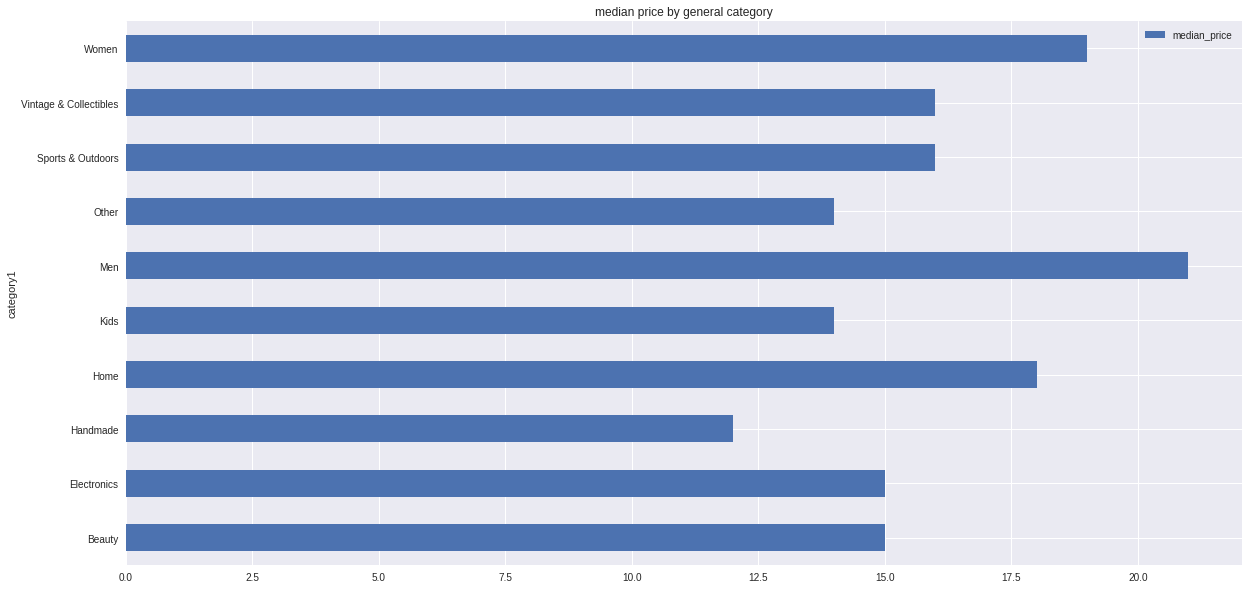

In [25]:
category1Price.plot(y="median_price", kind="barh", figsize=(20,10), title="median price by general category")
category1Price.sort_values("count", ascending=False)

In [26]:
subcategories = train.groupby(["category1", "category2","category3"]).agg({'category_name':'size', 'price':'median'}).rename(columns={'category_name':'count','price':'median_price'})

In [27]:
top30.head(10)

,median_price,count
category_name,,
Vintage & Collectibles/Antique/Furniture,195.0,1
Kids/Strollers/Standard,145.0,15
Home/Home Appliances/Air Conditioners,131.0,42
Kids/Strollers/Lightweight,105.0,18
Sports & Outdoors/Golf/Women's Golf Clubs,100.0,4
Electronics/Computers & Tablets/Laptops & Netbooks,100.0,1783
Kids/Strollers/Travel Systems,95.0,90
Women/Women's Handbags/Satchel,91.0,2331
Electronics/Computers & Tablets/Desktops & All-In-Ones,89.5,170


Sum of products in the top 30 categories: 623275
This 30 categories represent the 42.07% from the total training set


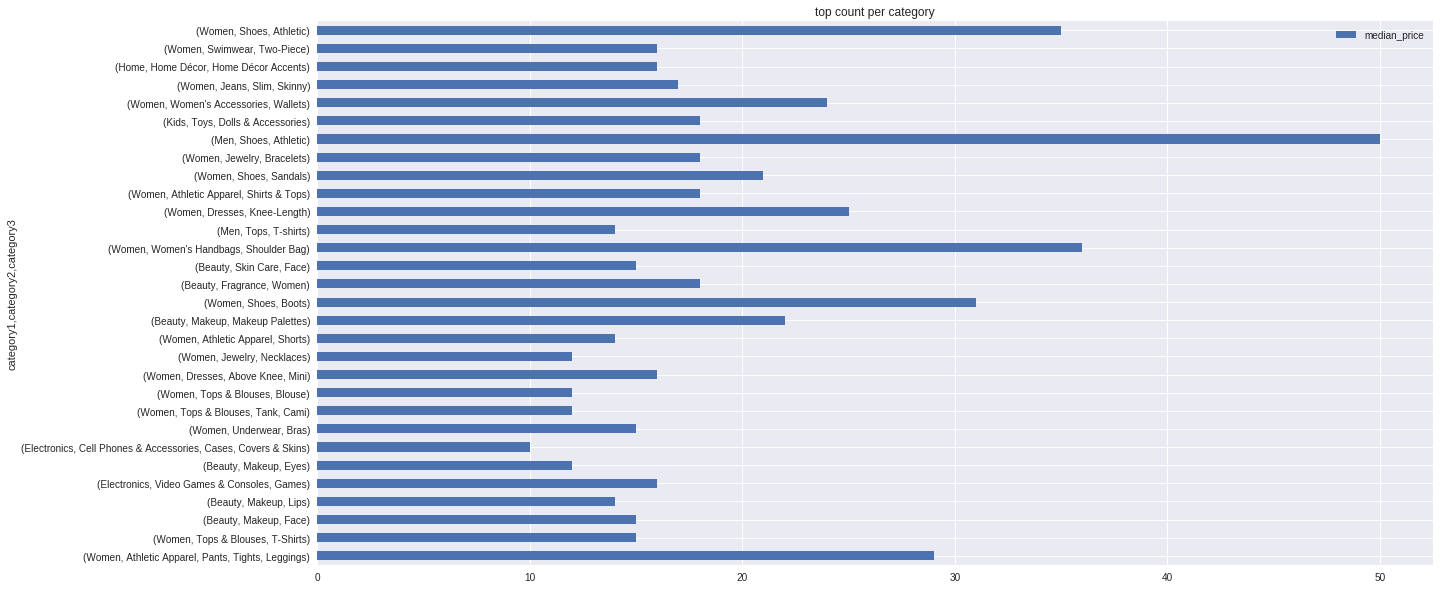

In [28]:
top30 = subcategories.sort_values("count", ascending=False).head(30)
top30.plot(y="median_price", kind="barh", figsize=(20,10), title="top count per category")
totalTop30 = top30["count"].sum()
print "Sum of products in the top 30 categories: " + str(totalTop30)
percentageFromTotalSet = (float(totalTop30) * 100.0) / float(len(train.index))
print('This 30 categories represent the %.2f' % percentageFromTotalSet + '% from the total training set')

If we take a closer look at the top 30 categories that have more items, we observe that they represent the 42% of the entire dataset. Moreover, the category "women" by itself represent more than 40% of the entire dataset with its 663990 instances. This could help us to understand how we should conduct the modelling or splitting the information. For instance, it might be possible that we create a model per category since it is clear that there is not a normal distribution among them. In contrast, it is shown above that "Sports & Outdoors" only has 25322 items, representing less than the 2%. 

#### 5) Brand Name

Most of the times, a brand define the price. That is, you expect a certain price for a product with a specific brand, compared to a similar product with another brand. For instance, it is not the same price of an iphone X with its competitor the Samsung Galaxy, or the price of a Gucci handbag with a similar one but with an unknown brand. The brand name analysis could help us to understand the price range by brand, the total number of brands and the amount of products without one. At the end we could define whether it is important or not, and the relationship with the price.

In [29]:
totalBrands = len(pd.value_counts(train['brand_name']))
itemsWithoutBrand = train['brand_name'].isnull().sum()
percentageWithoutBrand= (float(itemsWithoutBrand) * 100.0) / float(len(train.index))
brandPrice = train.groupby(["brand_name"]).agg({'brand_name':'size', 'price':'median'}).rename(columns={'brand_name':'count','price':'median_price'})

In [30]:
print "The total number of unique brands are: " + str(totalBrands) + ', products without brands are ' + str(itemsWithoutBrand) + ' the percentage of products without brand is %6.2f' %(percentageWithoutBrand)+ '%'

The total number of unique brands are: 4807, products without brands are 632336 the percentage of products without brand is  42.68%


In [31]:
brandPrice.sort_values("median_price", ascending=True).head(10)

,median_price,count
brand_name,,
AA Aquarium,3.0,1
Old Glory,3.0,1
Kae Argatherapie,3.0,1
A.B.S. by Allen Schwartz,3.0,1
Ask,3.0,1
Genica,3.0,1
Play MG,3.0,1
Archie Comics,3.0,1
Feetures!,3.0,1


In [32]:
brandPrice.sort_values("median_price", ascending=False).head(10)


,median_price,count
brand_name,,
Demdaco,429.0,2
Auto Meter,344.0,1
Proenza Schouler,315.5,4
Oris,300.0,1
Longines,254.0,1
Blendtec,250.0,5
Dainese,230.0,1
Frédérique Constant,224.0,1
David Yurman,220.0,242


In [33]:
brandPrice.sort_values("count", ascending=False).head(10)

,median_price,count
brand_name,,
PINK,20.0,54072
Nike,22.0,54006
Victoria's Secret,19.0,48011
LuLaRoe,29.0,30995
Apple,22.0,17314
FOREVER 21,12.0,15178
Nintendo,20.0,14998
Lululemon,39.0,14550
Michael Kors,49.0,13916


There are 4807 different brands. However, only 57% of the products have a brand, the rest does not have any value in this feature. The most common brands have a range median price between \$12 USD and \$49 USD, and the number of items is around 13000 and 55000. It is clear that the highest and lowest median prices contain only 1 item or few of them, except with the brand "David Yurman" that reported 242 items. The lowest median price is \$ 3 USD from several brands. In contrast, the most expensive median price is reported by "Demdaco" with \$ 429 USD in two items.

#### 6) Item Description

More information from the product might help to provide a better prediction. The item_description provides a brief explanation of each item which might contain valuable data to predict the price. Hence, a brief analysis is going to be conducted. First, the amount of product with and without description. Second, the minimum, maximum and mean length. Last, the relationship between the description length and the price.

In [34]:
mask = train.item_description == 'No description yet'
column_name = 'item_description'
train.loc[mask, column_name] = np.nan


In [35]:
train["item_description"].isnull().sum()

82431

In [36]:
train["item_description_length"] =  train['item_description'].str.len()


In [37]:
train["item_description_length"].describe(percentiles=[.25, .50, .75, .85, .95, .98])

count    1.399230e+06
mean     1.540517e+02
std      1.783732e+02
min      1.000000e+00
25%      4.600000e+01
50%      9.200000e+01
75%      1.830000e+02
85%      2.720000e+02
95%      5.420000e+02
98%      8.030000e+02
max      2.144000e+03
Name: item_description_length, dtype: float64

In [38]:
train.corr()

,train_id,item_condition_id,price,shipping,logprice,item_description_length
train_id,1.000000,-0.000116,0.000516,0.000496,0.000847,-0.000049
item_condition_id,-0.000116,1.000000,-0.000763,-0.191214,-0.001824,-0.136440
price,0.000516,-0.000763,1.000000,-0.097324,0.740434,0.043197
shipping,0.000496,-0.191214,-0.097324,1.000000,-0.231294,0.113681
logprice,0.000847,-0.001824,0.740434,-0.231294,1.000000,0.021536
item_description_length,-0.000049,-0.136440,0.043197,0.113681,0.021536,1.000000


From the entire products, there are 82431 that do not have any description. The maximum description length is 2144 characters including spaces, and the mean is 154. As seen in the table, there is no correlation between the price and the description length.

As seen in the last part, we can count the number of products that are telling us nothing. That is, products that do not have a brand, category, and description. With this filter, we can decide whether remove the products or try to fill them with other techniques.

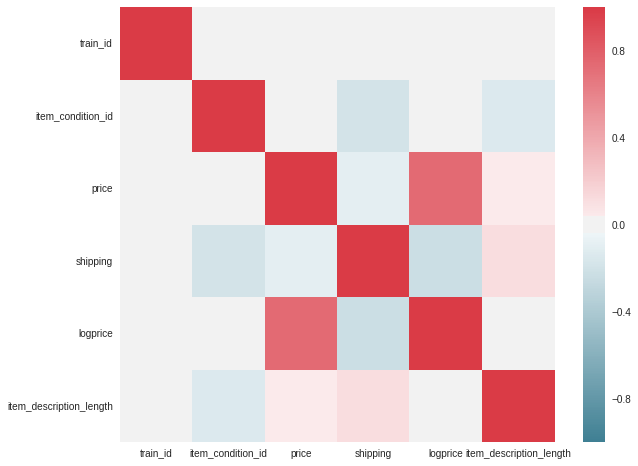

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [40]:
#train.columns.values
emptyCatBrandDesc = train.loc[(train['category_name'].isnull()) & (train["brand_name"].isnull()) & (train["item_description"].isnull())]

There are 428 products that meet the condition where brand, category, and description is empty. Overall, the name is self-explanatory or contains the brand. For example, the item ID 32313 with the name "Tommy Hilfiger Jeans" up to a certain point we could try to find a category, but we do not know more about. Another example is the id 50147 "PINK/Victoria Secret Sweatshirt" in this case we can certainly know that the category is under women cloth. However, most of the products do not contain much information and we should decide whether are valuable for the model or could represent noise. Another approach could be to create a new column adding the name, category, brand, and description to have all the string features in just one column.

## Pre-processing

In this section, we will focus on the discrete values such as name, category_name, brand_name, and item_description. Although item_condition_id and shipping are also discrete values, at this moment I do not consider that they require any treatment. Previously, we had modified the price with the Log function, and remove prices with a value equal to \$ 0 USD due to the fact that in reality, none item could value \$0 USD.

As a first step, we can remove the train_id, category_name, item_description_length, price. Train_id does not provide any value for the model, is just a consecutive. Category_name was split in the previous section, this column is extra since we have 3 new from this one called "category1", "category2", and "category3". Item_description_length was created to calculate the correlation between the price and the length, after the results it is not needed anymore. Since we have the logprice, price is not required anymore.Then, we will follow some best practices to clean and process strings[1]

[1] https://www.kdnuggets.com/2017/02/natural-language-processing-key-terms-explained.html

In [41]:
train = train.drop(['train_id', 'item_description_length', 'category_name', 'price','logprice'], axis=1)


1) Set to lower case all the features

In [42]:
train['name'] = train['name'].str.lower()
train['brand_name'] = train['brand_name'].str.lower()
train['item_description'] = train['item_description'].str.lower()
train['category1'] = train['category1'].str.lower()
train['category2'] = train['category2'].str.lower()
train['category3'] = train['category3'].str.lower()


2) Remove stop words

In [43]:
stop_words = set(stopwords.words('english'))

train['name_without_stop'] = train['name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

train['brand_name'] = train['brand_name'].astype(str)
train['brand_without_stop'] = train['brand_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['brand_without_stop'] = train['brand_without_stop'].replace('nan', '', regex=True)

train['item_description'] = train['item_description'].astype(str)
train['item_description_without_stop'] = train['item_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['item_description_without_stop'] = train['item_description_without_stop'].replace('nan', '', regex=True)

train['category1'] = train['category1'].astype(str)
train['category1_without_stop'] = train['category1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['category1_without_stop'] = train['category1_without_stop'].replace('nan','other', regex=True)

train['category2'] = train['category2'].astype(str)
train['category2_without_stop'] = train['category2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['category2_without_stop'] = train['category2_without_stop'].replace('nan', '', regex=True)

train['category3'] = train['category3'].astype(str)
train['category3_without_stop'] = train['category3'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['category3_without_stop'] = train['category3_without_stop'].replace('nan', '', regex=True)

train = train.drop(['name','brand_name', 'item_description','category1','category2','category3'], axis=1)


3) Remove punctuation

In [44]:
train["name_without_stop"] = train['name_without_stop'].str.replace('[^\w\s]','')
train["brand_without_stop"] = train['brand_without_stop'].str.replace('[^\w\s]','')
train["item_description_without_stop"] = train['item_description_without_stop'].str.replace('[^\w\s]','')
train["category1_without_stop"] = train['category1_without_stop'].str.replace('[^\w\s]','')
train["category2_without_stop"] = train['category2_without_stop'].str.replace('[^\w\s]','')
train["category3_without_stop"] = train['category3_without_stop'].str.replace('[^\w\s]','')

4) Lemmatization the name and item description

In [21]:
import nltk as nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # for easy if-statement 
    
def LemaWord(word):
    tagged = nltk.tag.pos_tag([word])
    word, tag = tagged[0]
    wntag = get_wordnet_pos(tag)
    lemma = lemmatizer.lemmatize(word, pos=wntag)
    return lemma
        
#train['name_without_stop'] = train['name_without_stop'].apply(lambda x: ' '.join([ LemaWord(word) for word in x.split()]))
#train['item_description_without_stop'] = train['item_description_without_stop'].apply(lambda x: ' '.join([LemaWord(word) for word in x.split()]))


The lemmatizer process takes a lot of time, in order to not running everytime, I stored the dataframe in a csv.

In [45]:
#train.to_csv(path_or_buf="../trainAfterLemmalizer.csv", sep=",", )
train = pd.read_csv('trainAfterLemmalizer.csv', index_col=0)

/home/casertillo/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [46]:
#set all features as string
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['shipping'] = train['shipping'].astype(str)
train['name_without_stop'] = train['name_without_stop'].fillna('').astype(str)
train['brand_without_stop'] = train['brand_without_stop'].fillna('').astype(str)
train['item_description_without_stop'] = train['item_description_without_stop'].fillna('').astype(str)
train['category1_without_stop'] = train['category1_without_stop'].fillna('').astype(str)
train['category2_without_stop'] = train['category2_without_stop'].fillna('').astype(str)
train['category3_without_stop'] = train['category3_without_stop'].fillna('').astype(str)

After these 4 steps conducted in the name and description we can review them again to understand their distribution, the unique words, their frequency, etc.

In [47]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

train['full_description'] = train['name_without_stop'] + ' ' + train['item_description_without_stop'] 

#split the sentence to get each word as value in a list.
train['name_without_stop'] = train['name_without_stop'].str.split()
train['item_description_without_stop'] = train['item_description_without_stop'].str.split()

#the name and description sometimes got the same 
train['full_description'] = train['full_description'].str.split()


In [48]:
#count the number of words in each feature
train['count_name'] = train['name_without_stop'].apply(lambda x: len(x))
train['count_description'] = train['item_description_without_stop'].apply(lambda x: len(x))

In [49]:
train["count_name"].describe(percentiles=[.5, .75, .85, .95])

count    1.481661e+06
mean     4.125052e+00
std      1.523331e+00
min      0.000000e+00
50%      4.000000e+00
75%      5.000000e+00
85%      6.000000e+00
95%      7.000000e+00
max      1.300000e+01
Name: count_name, dtype: float64

In [50]:
train["count_description"].describe(percentiles=[.5, .75, .85, .9, .95])

count    1.481661e+06
mean     1.773811e+01
std      2.030410e+01
min      0.000000e+00
50%      1.100000e+01
75%      2.100000e+01
85%      3.100000e+01
90%      4.100000e+01
95%      6.100000e+01
max      1.930000e+02
Name: count_description, dtype: float64

In [51]:
print('Instances with a name longer than 7 words: ' + str(len(train.loc[train['count_name'] > 7])))
print('Instances with a description longer than 61 words: ' + str(len(train.loc[train['count_description'] > 61])))
print('Instances with both, a name > 7 and a description > 61 words: ' + str(len(train.loc[(train['count_description'] > 61) & (train['count_name'] > 7)])))

Instances with a name longer than 7 words: 15317
Instances with a description longer than 61 words: 72297
Instances with both, a name > 7 and a description > 61 words: 2016


As shown above, the average number of words for the name and de description are 41.2 and 17.7 respectively. Up to the 95%, the name is from 7 words and the description is 61. Although, we can find names with 13 words and descriptions with 193. After a simple count in total, there are 87614 unique instances that have either a name longer than 7 words or a description that exceeds 61 words. In contrast, there are 2016 instances where both conditions are met.

With this information, we can reduce the number of words in those instances and try to optimize the processing time. I had to conduct this analysis after several attempts to run different models that never finished due to the number of dimensions.

In [52]:
#Since the name and the description have similarities, 
#I will use the full_description to analyse the usage of the words in both features.
full_description = train['full_description'].tolist()

In [53]:
import itertools
#each instance has a list of full_description, we will conver it in a flat list.
merged = list(itertools.chain(*full_description))

In [54]:
from nltk.probability import FreqDist
fdist = FreqDist(merged)

In [55]:
unique_words = len(fdist)
words_used = len(merged)
freq = float(words_used)/float(unique_words)
print('In total there are ' + str(unique_words) + ' unique words') 
print('From these words, they are used ' + str(words_used) + ' times, around ' +str(round(freq, 2)) + ' each on average.') 

In total there are 334316 unique words
From these words, they are used 32393798 times, around 96.9 each on average.


In [56]:
print('There are ' + str(len(fdist.hapaxes())) + ' words with only one occurance. That is, used only one time, more than half of the words. Around   61% of the words are used only one time')

There are 205159 words with only one occurance. That is, used only one time, more than half of the words. Around   61% of the words are used only one time


In [57]:
#most frequent words
fdist.most_common(20)

[('new', 566352),
 ('size', 551746),
 ('free', 294255),
 ('brand', 290607),
 ('condition', 258852),
 ('use', 234685),
 ('shipping', 234534),
 ('bundle', 224183),
 ('rm', 214864),
 ('pink', 201385),
 ('black', 199311),
 ('worn', 186995),
 ('color', 175879),
 ('price', 174810),
 ('2', 172304),
 ('never', 158947),
 ('great', 155574),
 ('1', 139198),
 ('small', 137404),
 ('one', 136953)]

The top 2 words which are 'new' and 'size' are used in more than a third of the entire instances each. Then, the 8 following words 'free', 'brand', 'condition', 'use', 'shipping', 'bundle', 'rm', 'pink' are used more than 200 thousand times. As seen, most of the words are related to the condition, the shipping, and colours. 

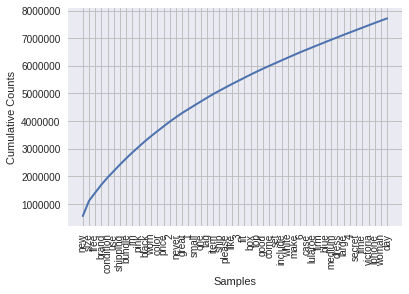

In [58]:
fdist.plot(50, cumulative=True)

In [59]:
print('The top 50 words cover around ' + str(round((8000000.0/len(merged))*100, 2)) + '% of the total words used.')

The top 50 words cover around 24.7% of the total words used.


5) Conduct One-Hot encoding

In [9]:
#Remove the exceding words in the name and description
train['name_without_stop'] = train['name_without_stop'].apply(lambda x: x[:7] if len(x) > 7 else x)
train['item_description_without_stop'] = train['item_description_without_stop'].apply(lambda x: x[:61] if len(x) > 61 else x)

In [35]:
#Here we conduct an analysis as the previous one with the full description
#But with only the name and description to determine the vector size of each one
name_list = train['name_without_stop'].tolist()
description_list = train['item_description_without_stop'].tolist()

merge_name = list(itertools.chain(*name_list))
merge_description = list(itertools.chain(*description_list))

fdistname = FreqDist(merge_name)
fdistdescription = FreqDist(merge_description)

unique_words = len(fdistname)
words_used = len(merge_name)
freq = float(words_used)/float(unique_words)
print('In total there are ' + str(unique_words) + ' unique words in the name') 
print('From these words, they are used ' + str(words_used) + ' times, around ' +str(round(freq, 2)) + ' each on average.') 

unique_words = len(fdistdescription)
words_used = len(merge_description)
freq = float(words_used)/float(unique_words)
print('In total there are ' + str(unique_words) + ' unique words in the description') 
print('From these words, they are used ' + str(words_used) + ' times, around ' +str(round(freq, 2)) + ' each on average.') 

In total there are 131516 unique words in the name
From these words, they are used 6095108 times, around 46.34 each on average.
In total there are 256793 unique words in the description
From these words, they are used 24480565 times, around 95.33 each on average.


In [ ]:
print('There are ' + str(len(fdistname.hapaxes())) + ' words used only once in the name, around 62%. ')
print('There are ' + str(len(fdistdescription.hapaxes()))+ ' words used only once in the description, around 62%')

After we reduced the number of words in the name and the description to the 95% of the instances. We conducted the same analysis in order to know the word usage and specify the maximum number of dimension in each feature. If we conduct a simple vectorization in the name and description the total amount of vectors could be of 388309 plus the other features. However, most of the values would be zeros. 

As mentioned before, I had to conduct this analysis since I had tried to work with the entire dimensions without success. Now, we can reduce the number of dimensions up to 48 percent in the name and description. Hence, the maximum features in the name after vectorization would be 49976 and the description 97581, based on words that are used more than once. 

In [10]:
#TfidfVectorizer expect a list of strings. Thus, we move back the list of words to a string
train['name_without_stop'] = train['name_without_stop'].apply(lambda x: ' '.join([word for word in x]))
train['item_description_without_stop'] = train['item_description_without_stop'].apply(lambda x: ' '.join([word for word in x]))

train["item_description_without_stop"] = train['item_description_without_stop'].str.replace('nan','')
train['categories'] = train['category2_without_stop'] + ' ' + train['category3_without_stop']

train = train.drop(['full_description', 'count_name','count_description', 'category2_without_stop','category3_without_stop'], axis=1)

train.rename(columns={'name_without_stop': 'name', 'item_description_without_stop' : 'description','item_condition_id': 'condition', 'category1_without_stop': 'category', 'brand_without_stop':'brand'}, inplace=True)

In [5]:
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

In [36]:
%%time

Features = FeatureUnion([('condition', 
                          CountVectorizer(token_pattern='\d+',
                                          preprocessor=build_preprocessor('condition'))),
                         ('shipping', 
                          CountVectorizer(token_pattern='\d+',
                                          preprocessor=build_preprocessor('shipping'))),
                        ('brand', 
                          CountVectorizer(token_pattern='\d+',
                                          preprocessor=build_preprocessor('brand'))),
                        ('category', 
                          CountVectorizer(token_pattern='.+',
                                          preprocessor=build_preprocessor('category'))),
                        ('categories', 
                          CountVectorizer(token_pattern='.+',
                                          preprocessor=build_preprocessor('categories'))),
                        ('name', 
                          TfidfVectorizer(ngram_range=(1, 2),
                                          max_features=49000,
                                          preprocessor=build_preprocessor('name'))),
                        ('description', 
                          TfidfVectorizer(ngram_range=(2, 3),
                                          max_features=97000,
                                          preprocessor=build_preprocessor('description'))),
                        ])

Features.fit(train.values)

#Source: https://www.kaggle.com/lopuhin/eli5-for-mercari

CPU times: user 9min 27s, sys: 14.9 s, total: 9min 42s
Wall time: 10min 58s


In [16]:
%%time
X_train = Features.transform(train.values).astype(np.float32)
X_train

CPU times: user 6min 23s, sys: 6.34 s, total: 6min 29s
Wall time: 6min 27s


In [17]:
reset_selective Features

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [15]:
#np.savez('X_trainMatrix', data=X_train.data, indices=X_train.indices,
#             indptr=X_train.indptr, shape=X_train.shape)

def save_sparse_csr(filename, sparseMatrix):
    np.savez(filename, data=sparseMatrix.data, indices=sparseMatrix.indices,
             indptr=sparseMatrix.indptr, shape=sparseMatrix.shape)
    
def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])



In [ ]:
save_sparse_csr('X_trainMatrix', X_train)

In [9]:
X_train = load_sparse_csr('X_trainMatrix')

## Preliminary Results

In this section, the baseline model is presented. During the proposal, the selected model was the Nearest Neighbors regression as it is considered as not optimal, based on the current literature.

   There is one step before conducting the regression with NN, which is to define the number of clusters. The number of general categories was selected for simplicity, the default number of 5 could have been selected as well. However, after few testing, the number of 10 provided better results. 
  

1) Metric function

In [16]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(y_pred[i] - y[i]) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

#Source: https://www.kaggle.com/marknagelberg/rmsle-function

2) Split train and test

In [10]:
X_train = np.around(X_train, 5)
LogPrices = np.around(LogPrices, 5)
X_train = X_train.astype(np.float32)
LogPrices = LogPrices.astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(X_train, LogPrices, train_size=0.80, random_state=42)


In [11]:
del X_train, train, prices, features, LogPrices
gc.collect()


33

3) Results with default settings expect number of neighbors 

In [9]:
%%time
#train
#number 10 is based on the first 10 categories
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(x_train, y_train)

CPU times: user 292 ms, sys: 116 ms, total: 408 ms
Wall time: 1.06 s


Due to the amount of dimensions and file size we create a temporary file to have it in memory

In [30]:
temp_folder = tempfile.mkdtemp()
filename = os.path.join(temp_folder, 'joblib_test.mmap')
if os.path.exists(filename): os.unlink(filename)
_ = dump(x_test, filename)
large_memmap = load(filename, mmap_mode='r+')

In [31]:
del x_train, y_train, x_test
gc.collect()

0

These functions were created to run the prediction in parallel. After testing, a single thread could only support around 400 instances and used to take around 5 minutes. More instances threw a memory error. 

In [12]:
%%time
def _predict(estimator, X, method, start, stop, max_size):
    if stop > max_size:
        stop = max_size
    return getattr(estimator, method)(X[start:stop])

def parallel_predict(estimator, X, n_jobs=1, method='predict', batches_per_job=4):
    n_jobs = max(n_jobs, 1)  
    n_batches = batches_per_job * n_jobs
    n_samples = X.shape[0]
    batch_size = int(np.ceil(n_samples / n_batches))
    parallel = Parallel(n_jobs=n_jobs)
    results = parallel(delayed(_predict)(estimator, X, method, i, i + batch_size, n_samples)
                       for i in range(0, n_samples, batch_size))
    if sp.issparse(results[0]):
        return sp.vstack(results)
    return np.concatenate(results)
#reference https://github.com/scikit-learn/scikit-learn/issues/7448

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 40.1 µs


In [13]:
%%time
predictions = parallel_predict(neigh, large_memmap[:40000], 6, 'predict', 100)


CPU times: user 12min 20s, sys: 2.53 s, total: 12min 23s
Wall time: 29min 5s


In [14]:
print "The rmsle for the default values with KNN regressions is: " + str(rmsle(y_test[:40000].tolist(), predictions))

The rmsle for the default values with KNN regressions is: 0.559637939517


In [35]:
#os.remove(filename)
del large_memmap
gc.collect()

0

As seen, the K-NN provides a rmsle of 0.5596, which is better than many results found in the leaders' board in the kaggle competition, but far from a competitive one. 

An important aspect of this section is the use of memory and work with parallel functions. Due to the dimension size, training and testing size, a lot effort had to be invested to test more than 400 instances as mentioned previously. Attempts to predict the entire testing set were made but either had memory errors or the process never ended.

The maximum testing instances were 40000 without crashing and in an acceptable period of time, 100 times more than a predefined configuration was able to work with. But more importantly, was able to predict the values without crashing which was the main problem.

The computer specifications are: <br>
OS: Ubuntu 16.04 64-bit <br>
Processor: Intel® Core™ i7-2670QM CPU @ 2.20GHz × 8 <br>
Graphics: GeForce GT 525M/PCIe/SSE2 <br>
RAM: 8 GB <br>

Any suggestion in this area to improve is welcome.

## Feature Selection

In this section, we select only the most important features. Previously, we have removed the prices with a value equal to zero because mercari does not allow prices with zero. Then, we reduce the length of the name and description dues to dimensionality. Now, we are going to use two options from sklearn, 1) max_def from the method TfidfVectorizer when creating the matrix, and 2) SelectPercentile from feature_selection.

We need to recreate the vector called "Features" with the max_def functions and then apply SelectPercentile.

In [13]:
%%time
#We use max_def in name and description
Features = FeatureUnion([('condition', 
                          CountVectorizer(token_pattern='\d+',
                                          preprocessor=build_preprocessor('condition'))),
                         ('shipping', 
                          CountVectorizer(token_pattern='\d+',
                                          preprocessor=build_preprocessor('shipping'))),
                        ('brand', 
                          CountVectorizer(token_pattern='\d+',
                                          preprocessor=build_preprocessor('brand'))),
                        ('category', 
                          CountVectorizer(token_pattern='.+',
                                          preprocessor=build_preprocessor('category'))),
                        ('categories', 
                          CountVectorizer(token_pattern='.+',
                                          preprocessor=build_preprocessor('categories'))),
                        ('name', 
                          TfidfVectorizer(ngram_range=(1, 2),
                                          max_features=49000,
                                          max_df=0.5,
                                          sublinear_tf=True,
                                          preprocessor=build_preprocessor('name'))),
                        ('description', 
                          TfidfVectorizer(ngram_range=(2, 3),
                                          max_features=97000,
                                          max_df=0.5,
                                          sublinear_tf=True,
                                          preprocessor=build_preprocessor('description'))),
                        ])

Features.fit(train.values)

CPU times: user 7min 52s, sys: 10 s, total: 8min 2s
Wall time: 8min 16s


In [14]:
%%time
#tranform as the previous step
X_train = Features.transform(train.values).astype(np.float32)

CPU times: user 5min 19s, sys: 4.47 s, total: 5min 23s
Wall time: 5min 28s


In [16]:
#np.savez('X_trainMatrixV2', data=X_train.data, indices=X_train.indices,
#             indptr=X_train.indptr, shape=X_train.shape)

In [17]:
X_train = load_sparse_csr('X_trainMatrixV2')

In [18]:
#split the entire X_train 
X_train = X_train.astype(np.float32)
LogPrices = LogPrices.astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(X_train, LogPrices, train_size=0.80, random_state=42)

In [9]:
x_train

<1185328x147242 sparse matrix of type '<type 'numpy.float32'>'
	with 24465468 stored elements in Compressed Sparse Row format>

In [10]:
x_test

<296333x147242 sparse matrix of type '<type 'numpy.float32'>'
	with 6121163 stored elements in Compressed Sparse Row format>

In [48]:
%%time
#Select a percentile of features
from functools import partial
#define the f_regression
f_regress = partial(f_regression, center=False)
#we will use only the 20 percent of the instances
feature_selector = SelectPercentile(f_regress, percentile=10)
#fit the training values
feature_selector.fit(x_train, y_train)

CPU times: user 5.18 s, sys: 608 ms, total: 5.78 s
Wall time: 5.79 s


In [49]:
%%time
#transform the training and testing values
x_train = feature_selector.transform(x_train)
x_test = feature_selector.transform(x_test)

CPU times: user 1.45 s, sys: 140 ms, total: 1.59 s
Wall time: 1.6 s


## Models Development

1) Decision tree regression

In [50]:
%%time
from sklearn.tree import DecisionTreeRegressor
#We run the tree with the defaul values
regressor = DecisionTreeRegressor()

regressor.fit(x_train[:20000], y_train[:20000])

CPU times: user 24.2 s, sys: 12 ms, total: 24.2 s
Wall time: 24.4 s


In [51]:
%%time
y_predictions = regressor.predict(x_test)

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 296 ms


In [52]:
print "The rmsle for the default values with a decision tree regression is: " + str(rmsle(y_test.tolist(), y_predictions))

The rmsle for the default values with a decision tree regression is: 0.751344189687


2) Linear Regression

In [47]:
%%time
from sklearn.linear_model import LinearRegression
#We run the tree with the defaul values
lr = LinearRegression(n_jobs=-1)

lr.fit(x_train[:20000], y_train[:20000])

CPU times: user 8min 10s, sys: 20.9 s, total: 8min 30s
Wall time: 2min 8s


In [48]:
%%time
y_predictions = lr.predict(x_test)

CPU times: user 176 ms, sys: 12 ms, total: 188 ms
Wall time: 47.1 ms


In [49]:
print "The rmsle for the default values with a linear regression is: " + str(rmsle(y_test.tolist(), y_predictions))

The rmsle for the default values with a linear regression is: 1.3545084208


3) Support Vector Regression (SVR)

In [41]:
%%time
from sklearn.svm import SVR
clf = SVR()
clf.fit(x_train[:20000], y_train[:20000])

CPU times: user 1min 23s, sys: 76 ms, total: 1min 23s
Wall time: 1min 23s


In [42]:
%%time
y_predictions = clf.predict(x_test)

CPU times: user 22min 27s, sys: 180 ms, total: 22min 27s
Wall time: 22min 27s


In [43]:
print "The rmsle for the default values with a SVR is: " + str(rmsle(y_test.tolist(), y_predictions))

The rmsle for the default values with a linear regression is: 0.721296427205


4) XGBoost

In [50]:
%%time
import xgboost as xgb

xgb = xgb.XGBRegressor()

xgb.fit(x_train, y_train)

CPU times: user 8min 51s, sys: 328 ms, total: 8min 51s
Wall time: 8min 51s


In [51]:
%%time
y_predictions = xgb.predict(x_test)

CPU times: user 1.19 s, sys: 4 ms, total: 1.2 s
Wall time: 1.19 s


In [52]:
print "The rmsle for the default values with a xgboost is: " + str(rmsle(y_test.tolist(), y_predictions))

The rmsle for the default values with a xgboost is: 0.634681729818


## Compare Results

During the previous section, 4 models were created with the default options in order to determine the best one. As seen, the best model comes from the 4th method "XGBoost" with a rmsle of 0.6351, followed by the SVR reporting 0.7212. XGBoost proved to be the best model not just by the metric, but also because it was able to handle the entire sample set in the least amount of time. Around 10 minutes for the training phase and approximately a second to predict 296333 instances. 

To clarify, XGBoost was first tested with only 20000 instances as the other models, providing similar results as the one presented with the entire instances.

In contrast, SVR took less time to train. However, it could not manage the entire training set due to a Memory error and the prediction time takes around 20 minutes.

It might be possible that at this stage we could define the KNN as the best one since it shows less rmsle with 0.5596. But, same as the SVR the prediction time takes a lot of time. For instance, only 40000 test instances took around 30 minutes, turning the model in not-optimal if we consider the time to train and predict. Points where the XGBoost outperforms its competitors.

## Tunning Model

At this stage we will select the best parameters for the XGBoost in order to reduce the rmsle.

In [19]:
%%time
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer
import xgboost as xgb
xgb = xgb.XGBRegressor()
parameters = {
                'max_depth': [18],
                'learning_rate': [0.19],
                'n_estimators': [92],
                'booster': ['gblinear'],
                'gamma':[0.0],
                'min_child_weight':[0],
                'max_delta_step':[0],
                'reg_alpha':[0.25],
                'reg_lambda':[1.1]  
            }

clf = GridSearchCV(xgb, parameters, cv=10)

clf.fit(x_train, y_train)

CPU times: user 14min 42s, sys: 9.1 s, total: 14min 51s
Wall time: 14min 51s


In [20]:
print clf.best_params_ 

{'reg_alpha': 0.25, 'learning_rate': 0.19, 'max_delta_step': 0, 'min_child_weight': 0, 'n_estimators': 92, 'reg_lambda': 1.1, 'max_depth': 18, 'gamma': 0.0, 'booster': 'gblinear'}


In [21]:
%%time
y_predictions = clf.predict(x_test)

CPU times: user 404 ms, sys: 52 ms, total: 456 ms
Wall time: 447 ms


In [22]:
print "The rmsle for the custom parameters with a xgboost is: " + str(rmsle(y_test.tolist(), y_predictions))

The rmsle for the custom parameters with a xgboost is: 0.467033042223


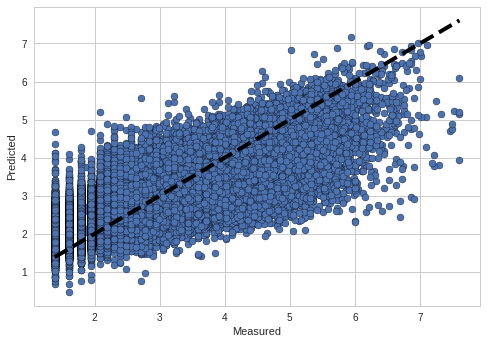

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, y_predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

After tunning the XGBoost parameters, there is a clear improvement.It started with 0.6351 and reduced the error 0.1244 to have a final rmsle of 0.5107, the best score obtained.

In the grid search above, there are presented only the final parameters. The process to obtain them was one by one, starting with a range of them. Then, they were reduced to get the best possible. The grid search was conducted with a sample of 15000 instances due to the time to try the entire training set.  

It is important to mention that while tunning, one of the most important tuning parameters was the "max_depth" just configuring it the improvement was of 0.10 in the error. Also, as the depth increased the time to training time did the same.

Compared with the results in the competitions, this model performs well by looking the best result which is 0.3777. If we put this result on the leaders board it would be right in the middle.

#### Model Robustness

In this section the testing is splitte in different folds and we review the RMSLE in each one.

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

kf = KFold(n_splits=20, shuffle=True, random_state=42)
cv_results = cross_val_score(clf, x_test, y_test.tolist(), cv=kf, scoring=rmsle_scorer)


In [31]:
print cv_results

[-0.49144967 -0.4900279  -0.49239336 -0.49535547 -0.49490726 -0.49421077
 -0.48585994 -0.4904778  -0.49210552 -0.49544221 -0.48033098 -0.49010733
 -0.49843175 -0.48931229 -0.48679669 -0.48721305 -0.48953899 -0.48542221
 -0.49365908 -0.48654719]
